In [1]:
from maskrcnn_benchmark.utils.env import setup_environment
import os

import torch
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.engine.inference import inference
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.utils.collect_env import collect_env_info
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from maskrcnn_benchmark.utils.logger import setup_logger
from maskrcnn_benchmark.utils.miscellaneous import mkdir

try:
    from apex import amp
except ImportError:
    raise ImportError('Use APEX for mixed precision via apex.amp')

from PIL import Image
import requests
from io import BytesIO
from maskrcnn_benchmark.data.transforms.build import my_build_transforms
from maskrcnn_benchmark.structures.image_list import *
import numpy as np
from maskrcnn_benchmark.structures.bounding_box import BoxList
import json

with open('datasets/vg/VG-SGG-dicts-with-attri.json', 'r') as f:
    info_dict = json.load(f)

def read_img_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

def refine_boxlist(boxlist, thres_obj=0.1, thres_rel=0.1):
    device = torch.device('cpu')
    
    size = boxlist.size
    mode = boxlist.mode
    
    bbox = boxlist.bbox.to(device)
    pred_scores = boxlist.get_field('pred_scores').to(device)
    pred_labels = boxlist.get_field('pred_labels').to(device)
    pair_obj = boxlist.get_field('rel_pair_idxs').to(device)
    rel_labels = boxlist.get_field('pred_rel_labels').to(device)
    rel_scores = boxlist.get_field('pred_rel_scores').to(device)
    
    rel_scores = rel_scores.numpy()
    rel_labels = rel_labels.numpy()
    pair_obj = pair_obj.numpy()
    pred_scores = pred_scores.numpy()
    pred_labels = pred_labels.numpy()
    bbox = bbox.numpy()
    
    # Remove detected object with lower score
    idx_low_pred_labels = np.where(pred_scores < thres_obj)[0]
    idx_high_pred_labels = np.asarray([x for x in range(len(pred_scores)) if x not in list(idx_low_pred_labels)])
    
    # Remove detected relation corresponding with low score detected object
    idx_pairs_contain_low_labels = [idx for idx, row in enumerate(pair_obj) if row[0] in idx_low_pred_labels or row[1] in idx_low_pred_labels]
    idx_pairs_contain_high_labels = [x for x in range(len(rel_scores)) if x not in idx_pairs_contain_low_labels]
    
    pairs_contain_high_labels = pair_obj[idx_pairs_contain_high_labels,:]
    rel_labels_contain_high_labels = rel_labels[idx_pairs_contain_high_labels]
    rel_scores_contain_high_labels = rel_scores[idx_pairs_contain_high_labels,:]
    pred_labels_contain_high_labels = pred_labels[idx_high_pred_labels]
    pred_scores_contain_high_labels = pred_scores[idx_high_pred_labels]
    bbox_contain_high_labels = bbox[idx_high_pred_labels,:]
    
    # Reindex object in the pairs object
    temp = list(idx_high_pred_labels)
    for i in range(pairs_contain_high_labels.shape[0]):
        row = pairs_contain_high_labels[i]
        pairs_contain_high_labels[i][0] = temp.index(row[0])
        pairs_contain_high_labels[i][1] = temp.index(row[1])
        
    # Should remove detected relation with lower score
    max_scores = np.max(rel_scores_contain_high_labels[:,1:], axis=1)
    idx_high_rel = np.where(max_scores > thres_rel)[0]
    pairs_contain_high_labels_high_rels = pairs_contain_high_labels[idx_high_rel,:]
    rel_labels_contain_high_labels_high_rels = rel_labels_contain_high_labels[idx_high_rel]
    rel_scores_contain_high_labels_high_rels = rel_scores_contain_high_labels[idx_high_rel,:]
    
    newboxlist = BoxList(bbox=bbox_contain_high_labels, image_size=size, mode=mode)
    newboxlist.add_field('pred_scores', pred_scores_contain_high_labels)
    newboxlist.add_field('pred_labels', pred_labels_contain_high_labels)
    newboxlist.add_field('pred_rel_labels', rel_labels_contain_high_labels_high_rels)
    newboxlist.add_field('pred_rel_scores', rel_scores_contain_high_labels_high_rels)
    newboxlist.add_field('rel_pair_idxs', pairs_contain_high_labels_high_rels)
    
    return newboxlist

def decode_relation(pair_array, rel_label_array, label_array, info_dict):
    # relation_array size n_relation (obj1, obj2) --> encoded to number
    # rel_label_array relation label # number encoded
    # label_array is detected object encoded object
    # len(relation_array) == len(label_array)
    result = []
    for i in range(pair_array.shape[0]):
        rel = pair_array[i]
        obj1 = info_dict['idx_to_label'][str(label_array[rel[0]])] + ':' + str(rel[0])
        obj2 = info_dict['idx_to_label'][str(label_array[rel[1]])] + ':' + str(rel[1])
        con = info_dict['idx_to_predicate'][str(rel_label_array[i])]
        result.append([obj1, con, obj2])
    return result

torch.cuda.set_device(1)
cpu_device = torch.device('cpu')
device = torch.device('cuda')
num_gpus = 1
distributed = num_gpus > 1

config_file = 'configs/e2e_relation_X_101_32_8_FPN_1x.yaml'
cfg.merge_from_file(config_file)
cfg.local_rank = 0
# cfg.merge_from_list(args.opts)
cfg.MODEL.ROI_RELATION_HEAD.USE_GT_BOX = False
cfg.MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL = False
cfg.MODEL.ROI_RELATION_HEAD.PREDICTOR = 'CausalAnalysisPredictor'
cfg.MODEL.ROI_RELATION_HEAD.CAUSAL.EFFECT_TYPE = 'none'
cfg.MODEL.ROI_RELATION_HEAD.CAUSAL.FUSION_TYPE = 'sum'
cfg.MODEL.ROI_RELATION_HEAD.CAUSAL.CONTEXT_LAYER = 'motifs'
cfg.TEST.IMS_PER_BATCH = 1
cfg.DTYPE = "float16"
cfg.GLOVE_DIR= '/mnt/DATA/nmduy/glove'
cfg.MODEL.PRETRAINED_DETECTOR_CKPT = '/mnt/DATA/nmduy/pretrained_faster_rcnn/pretrained_faster_rcnn/model_final.pth'
cfg.MODEL.DEVICE = 'cuda'
cfg.OUTPUT_DIR = '/home/nmduy/Scene-Graph-Benchmark.pytorch/pretrained_causal_motif_sgdet'

cfg.freeze()

model = build_detection_model(cfg)
model.to(cfg.MODEL.DEVICE);

my_transform = my_build_transforms(cfg, is_train=False)

# Initialize mixed-precision if necessary
use_mixed_precision = cfg.DTYPE == 'float16'
amp_handle = amp.init(enabled=use_mixed_precision, verbose=cfg.AMP_VERBOSE)

# Load model
output_dir = cfg.OUTPUT_DIR
checkpointer = DetectronCheckpointer(cfg, model, save_dir=output_dir)
_ = checkpointer.load(cfg.MODEL.WEIGHT)
model.eval();

iou_types = ("bbox",)
if cfg.MODEL.MASK_ON:
    iou_types = iou_types + ("segm",)
if cfg.MODEL.KEYPOINT_ON:
    iou_types = iou_types + ("keypoints",)
if cfg.MODEL.RELATION_ON:
    iou_types = iou_types + ("relations", )
if cfg.MODEL.ATTRIBUTE_ON:
    iou_types = iou_types + ("attributes", )


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/sgg/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


loading word vectors from /mnt/DATA/nmduy/glove/glove.6B.200d.pt
__background__ -> __background__ 
fail on __background__
loading word vectors from /mnt/DATA/nmduy/glove/glove.6B.200d.pt
__background__ -> __background__ 
fail on __background__


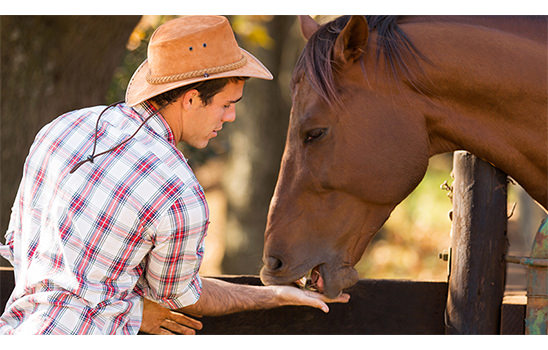

In [59]:
sample_url = 'https://standleeforage.com/images/email/nutrition/man_giving_horse_snack.jpg'
sample_img = read_img_from_url(sample_url)
original_size = sample_img.size
sample_img

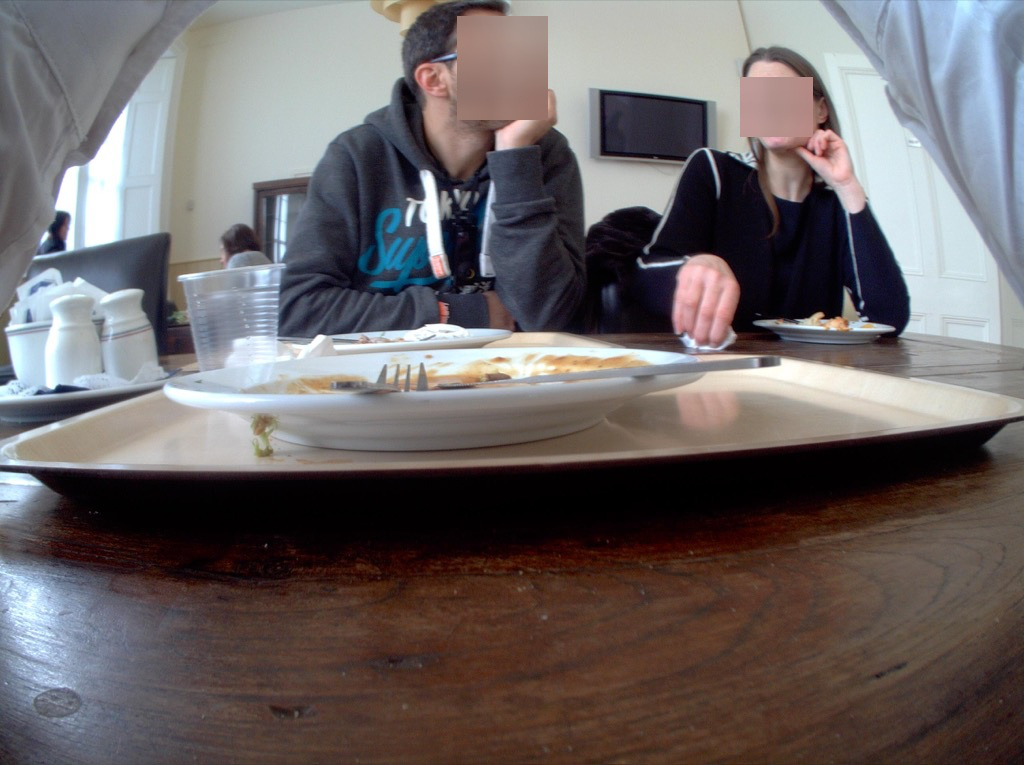

In [2]:
# Read image
DIR_DATA = '/mnt/DATA/lsc2020/2015-02-23'
FILE_NAME = 'b00000680_21i6bq_20150223_141128e.jpg'
sample_url = 'https://cs.stanford.edu/people/rak248/VG_100K/2342560.jpg'
sample_img = Image.open(f"{DIR_DATA}/{FILE_NAME}").convert("RGB")
original_size = sample_img.size
sample_img

In [3]:
# Transform to tensor format
sample_img_transform = my_transform(sample_img)
# Convert to ImageList Format
sample_img_transform_iml = to_image_list(sample_img_transform, size_divisible=cfg.DATALOADER.SIZE_DIVISIBILITY)

In [8]:
# Run the generation
torch.cuda.empty_cache()
with torch.no_grad():
    output = model(sample_img_transform_iml.to(device))
    output = output[0]

# resize to the original size and filter out low result
prediction = output.resize(original_size)

In [5]:
# Filter out low result
refine = refine_boxlist(prediction, thres_obj=0.25, thres_rel=5e-4)

In [6]:
# Decode to human read
relation_array = refine.get_field('rel_pair_idxs')
label_array = refine.get_field('pred_labels')
rel_labels = refine.get_field('pred_rel_labels')
decode_relation(relation_array, rel_labels, label_array, info_dict)

[['woman:6', 'wearing', 'shirt:7'],
 ['food:9', 'on', 'plate:1'],
 ['woman:6', 'has', 'hand:0'],
 ['cup:3', 'on', 'table:2'],
 ['cup:5', 'on', 'table:2'],
 ['woman:6', 'has', 'hand:8'],
 ['plate:1', 'on', 'table:2'],
 ['woman:6', 'holding', 'plate:1'],
 ['hand:0', 'of', 'woman:6'],
 ['hand:8', 'of', 'woman:6'],
 ['food:9', 'on', 'table:2'],
 ['plate:1', 'with', 'food:9']]

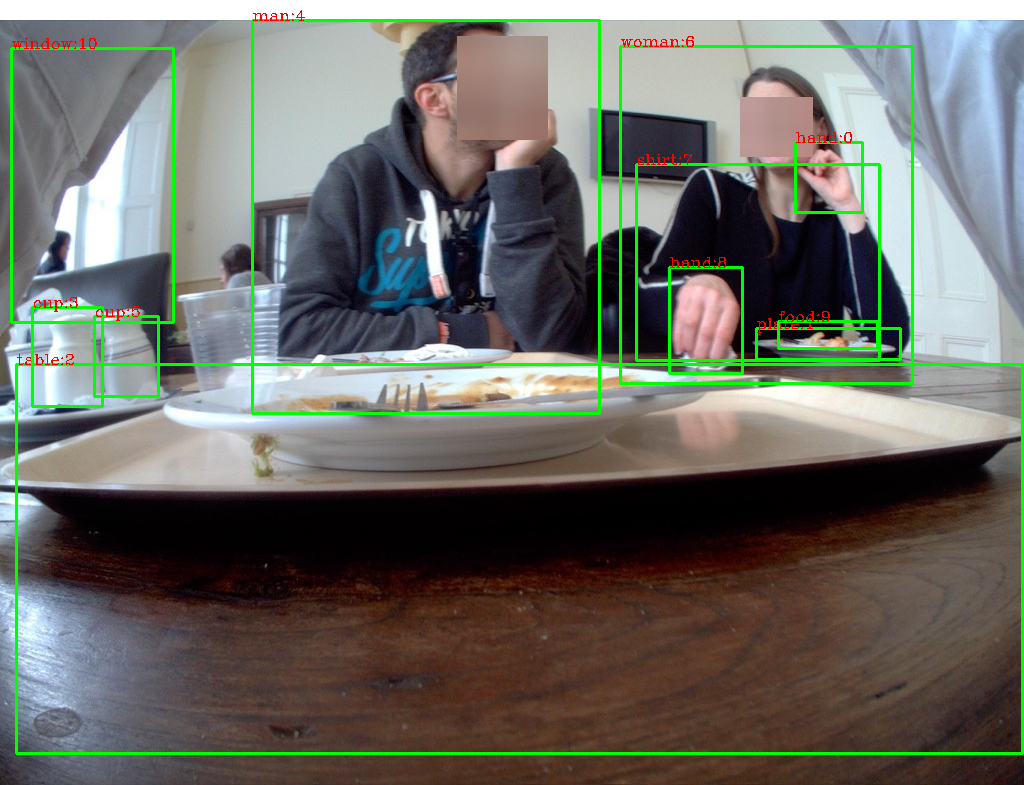

In [7]:
##### VISUALIZE ######
import cv2
import matplotlib.pyplot as plt

extend_row = 20
sample_img_np = np.asarray(sample_img)
black_extend = 255*np.ones((extend_row, original_size[0], 3), dtype='uint8')
sample_img_np = np.vstack((black_extend, sample_img_np))

bbox = refine.bbox.numpy()
bbox_label = refine.get_field('pred_labels')

for idx in range(0,bbox.shape[0]):
    box = bbox[idx]
    box = [int(x) for x in box]
    label = info_dict['idx_to_label'][str(bbox_label[idx])] + ':' + str(idx)
    cv2.rectangle(sample_img_np, (box[0], box[1]+extend_row), (box[2], box[3]+extend_row), (0, 255, 0), 2)
    cv2.putText(sample_img_np, label, (box[0], box[1]+extend_row), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0), 1)
    
temp = Image.fromarray(sample_img_np)
temp